# Imports

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from networkx.classes.reportviews import NodeView, EdgeView, OutEdgeView
from random_graph import RandomGraphBuilder

# Girvan-Newman Algorithm

In [2]:
import networkx as nx

def girvan_newman_animated(G: nx.Graph | nx.DiGraph) -> nx.Graph | nx.DiGraph:
    """
    Implementation of the Girvan-Newman algorithm for detecting communities in a graph
    by iteratively removing edges from the original graph. 
    :param G: The input networkx Graph or DiGraph object
    :return: A graph with a singular contracted node and zero edges
    """
    # Set up list of animation frames to record the steps
    animation_steps = []

    while G.number_of_edges() > 0 or G.number_of_nodes() > 1:
        # Get the dictionary of edges to betweenness values using networkx
        btwnss = nx.edge_betweenness_centrality(G)
        if len(btwnss) == 0:
            print("Graph missing an edge!")
            break
        # Store the highest betweenness value
        max_btwnss = max(btwnss.values())
        # Identify the list of all edges with the highest betweenness value
        edges = []
        for e in btwnss:
            if btwnss[e] == max_btwnss:
                edges.append(e)

        # For the sake of animation/visualization, we will only remove one edge at a time
        #   instead of dealing with ties like in the original implementation
        # Contract the edge(s) with the highest rank from the graph
        nx.algorithms.minors.contracted_edge(G, edges[0], self_loops=False, copy=False)
        # Relabel the new contracted node $e_0$ where $e_1$ is the linked node
        # We use a formatted string to concatenate the labels of both nodes
        nx.relabel_nodes(G, {edges[0][0]: f'{edges[0][0]}, {edges[0][1]}'}, copy=False)

        # Append the current MST nodes, MST edges, and queue for animation
        animation_steps.append((set(G.nodes), set(G.edges), btwnss, edges))

    # Finally, return the modified graph which should only have one node and zero edges
    return G, animation_steps

# Animation and Visualization

### `update_anim` function
This function is called to update the plot for each frame.

In [3]:
from typing import Mapping, Union

def update_anim(frame: tuple[set[NodeView], set[Union[EdgeView, OutEdgeView]], Mapping, list], graph, animation_steps, pos, ax):
    ax.clear()
    # Extract current state from frame
    nodes, all_edges, betweenness_dict, contracted_edges = frame
    G = nx.Graph()

    # On the final frame, draw the whole graph
    if frame == animation_steps[-1]:
        G.add_nodes_from(nodes)
        nx.draw(G, pos, ax=ax, node_color='lightgrey', edge_color='lightgrey', with_labels=True)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_color='grey')
    else:
        # Draw a graph from the set and edges
        edges = []
        for edge, betweenness in betweenness_dict.items():
            edges.append((*edge, {'weight': round(betweenness, 4)}))
        G.add_edges_from(edges)

        # Find any nodes that are not in the graph and add them too
        all_nodes = set(nodes)
        for node in nodes:
            # If the node is contracted, split the label into a list of subnodes
            if isinstance(node, str):
                all_nodes.remove(node)
                node = node.split(', ')
                for n in node:
                    all_nodes.add(n)
            else:
                node = [node]

            G.add_nodes_from(n for n in node if n not in all_nodes)

        pos = nx.shell_layout(G)

        # Draw the full graph in grey with edge weights
        nx.draw(G, pos, ax=ax, node_color='lightgrey', edge_color='lightgrey', with_labels=True)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_color='grey')

        # Highlight edges with highest betweenness and connected nodes in red
        nx.draw_networkx_edges(G, pos, edgelist=[contracted_edges[0]], edge_color='red', ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[*contracted_edges[0]], node_color='red', ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={contracted_edges[0]: edge_labels[contracted_edges[0]]}, ax=ax, font_color='red')

### Graph Generation

#### Determine graph variables

In [4]:
num_nodes = random.randint(5, 12)
max_edges = (num_nodes * (num_nodes - 1)) / 2
exp_edges = random.randint(num_nodes - 1, max_edges)
edge_density = exp_edges / max_edges

#### Build a Graph object

In [5]:
G = RandomGraphBuilder() \
    .nodes(num_nodes) \
    .random_edges(edge_density) \
    .weighted(range(1,10)) \
    .build()

#### Plot the initial Graph

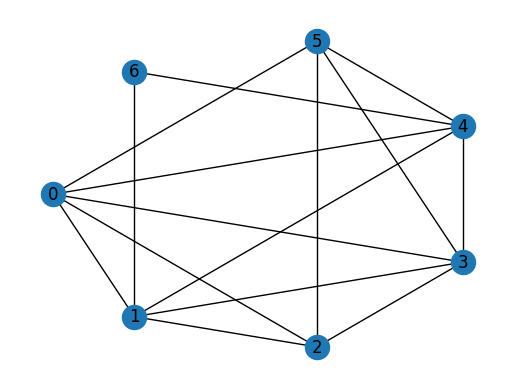

In [6]:
pos = nx.shell_layout(G)
fig, ax = plt.subplots()
nx.draw(G, pos, ax=ax, with_labels=True)

## Run the algorithm

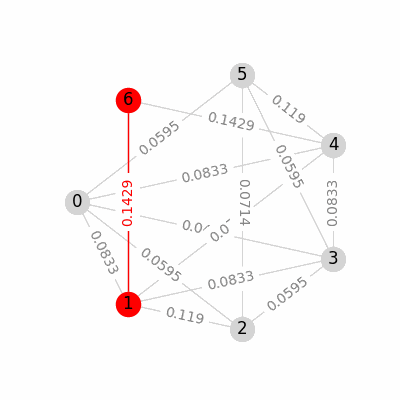

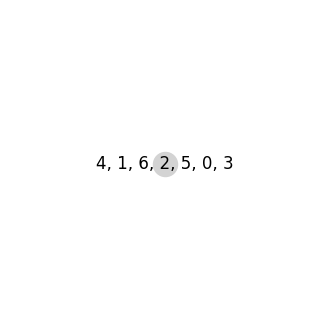

In [7]:
# Run the Girvan-Newman algorithm with animation step tracking
communities, animation_steps = girvan_newman_animated(G)
animation_steps.append((set(G.nodes), set(G.edges), {}, []))

# Set up the plot
fig, ax = plt.subplots(figsize=(4, 4))
pos = nx.shell_layout(G)  # Use shell_layout to avoid nodes on top of edges

# Finally, create the animation
FuncAnimation(fig, update_anim, frames=animation_steps, fargs=(G, animation_steps, pos, ax), interval=1000, repeat=False).save("girvan_newman_animation.gif", writer='pillow', fps=0.5)

# And display the animation in a way that jupyter supports
Image(filename="girvan_newman_animation.gif")